In [57]:
import torch
import torch.nn as nn
import numpy as np
from torch import tensor, sin, pi
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import random_split, TensorDataset

## PINNs for solving PDEs

Physics Informed Neural Networks (PINNS) are neural networks that incorporate physics, often described by a PDE, into the training process. This allows the network to be more robust and generalizable by not only learning from the data but also adhering to the underlying physics describing the data. Here, the approach begins with a 1D example problem and is then generalized to solve eigenvalue problems in higher dimensions.

The idea here is to use neural networks to approximate the solution $u$ to this PDE, leveraging their well-known ability as universal function approximators and also automatic differentiation to differentiate the output with respect to their input coordinates.

## 1D problem

Consider the following reaction-diffusion equation in 1D
$$
\begin{align*}
    -\Delta u + u &= (m^2\pi^2+1)\sin(m\pi x),\hspace{10pt}\text{ in }(0,1)\\
    u(0)&=u(1)=0
\end{align*}
$$

This PDE can be solved analytically and the exact solution is given by $u(x) = \sin(m\pi x)$.

In [2]:
# RHS
def f(x,m=1):
    return (m**2*pi**2+1)*sin(m*pi*x)

# Exact Solution
def u_exact(x,m=1):
    return sin(m*pi*x)

### Creating neural network

In [3]:
# building PINN neural network using nn.Module class
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 512),           # here 1 describes that we are working in 1D
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [4]:
# incorporating automatic differentiation
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),create_graph=True)[0]

### Loss function

The key idea of PINNs is to incorporate the PDE directly into the loss function along with the boundary conditions. This can be thought of as penalizing the network prediction wherever it deviates from the governing PDE and boundary conditions. The gradients arising in the PDE can be easily computed using automatic differentiation. 

The parameters of the neural networks can be learned by minimizing the mean-squared error loss function
$$
\begin{align*}
    MSE = MSE_u + MSE_f
\end{align*}
$$
where
$$
\begin{align*}
    MSE_b = |u(0)|^2 + |u(1)|^2
\end{align*}
$$
and
$$
\begin{align*}
    MSE_i = \frac{1}{N_i}\sum_{k=1}^{N_i} |-\Delta u(x_k) +u(x_k) - f(x_k)|^2
\end{align*}
$$
$N_i$ describes the number of collocation points which act as checkpoints to check whether the network prediction $u$ satisfies the PDE. $MSE_i$ describes the interior loss of network prediction, and $MSE_b$ describes the boundary loss. The collocation points, along with the endpoints, serve as training data for PINNs.

In [5]:
def compute_loss(model: nn.Module, x_train: torch.Tensor,m=1):
    # evaluating u(x), f(x), du/dx, d^2u/dx^2 at training data points
    x_train.requires_grad_(True)
    u = model(x_train)                      # model prediction on training data
    du = grad(u,x_train)
    d2u = grad(du,x_train)
    
    #ODE residual: -u"(x)+ u(x) - f(x)
    residual = -d2u[1:-1] + u[1:-1] - f(x_train[1:-1],m)     # ODE-based interior residual
    interior_loss = torch.mean(residual ** 2)              # mean-squared interior loss

    #calculating boundary loss for problem
    left_residual = model(x_train[0])
    right_residual = model(x_train[-1])
    boundary_loss = torch.mean(left_residual ** 2 + right_residual ** 2)    # mean-squared boundary loss

    return interior_loss + boundary_loss

Note that as $m$ increases, the exact solution becomes more oscillatory, making it more difficult to approximate using PINNs.

### Generating Training and test dataset

The training set consists of uniformly spaced points in the interval, totaling $n_{train} = N_i+2$ points, where $N_i$ is the number of datapoints in the interior. Initially, the case where $m=1$ is studied, and then $m$ is incrementally increased to assess the performance of PINNs.

In [6]:
# generate the training set
n_train = 11
x_train = torch.linspace(0,1,n_train).reshape(-1,1)
x_train

tensor([[0.0000],
        [0.1000],
        [0.2000],
        [0.3000],
        [0.4000],
        [0.5000],
        [0.6000],
        [0.7000],
        [0.8000],
        [0.9000],
        [1.0000]])

In [7]:
# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1)
x_test 

tensor([[0.0000],
        [0.0101],
        [0.0202],
        [0.0303],
        [0.0404],
        [0.0505],
        [0.0606],
        [0.0707],
        [0.0808],
        [0.0909],
        [0.1010],
        [0.1111],
        [0.1212],
        [0.1313],
        [0.1414],
        [0.1515],
        [0.1616],
        [0.1717],
        [0.1818],
        [0.1919],
        [0.2020],
        [0.2121],
        [0.2222],
        [0.2323],
        [0.2424],
        [0.2525],
        [0.2626],
        [0.2727],
        [0.2828],
        [0.2929],
        [0.3030],
        [0.3131],
        [0.3232],
        [0.3333],
        [0.3434],
        [0.3535],
        [0.3636],
        [0.3737],
        [0.3838],
        [0.3939],
        [0.4040],
        [0.4141],
        [0.4242],
        [0.4343],
        [0.4444],
        [0.4545],
        [0.4646],
        [0.4747],
        [0.4848],
        [0.4949],
        [0.5051],
        [0.5152],
        [0.5253],
        [0.5354],
        [0.5455],
        [0

In [8]:
y_test = u_exact(x_test)
y_test

tensor([[ 0.0000e+00],
        [ 3.1728e-02],
        [ 6.3424e-02],
        [ 9.5056e-02],
        [ 1.2659e-01],
        [ 1.5800e-01],
        [ 1.8925e-01],
        [ 2.2031e-01],
        [ 2.5115e-01],
        [ 2.8173e-01],
        [ 3.1203e-01],
        [ 3.4202e-01],
        [ 3.7166e-01],
        [ 4.0093e-01],
        [ 4.2979e-01],
        [ 4.5823e-01],
        [ 4.8620e-01],
        [ 5.1368e-01],
        [ 5.4064e-01],
        [ 5.6706e-01],
        [ 5.9291e-01],
        [ 6.1816e-01],
        [ 6.4279e-01],
        [ 6.6677e-01],
        [ 6.9008e-01],
        [ 7.1269e-01],
        [ 7.3459e-01],
        [ 7.5575e-01],
        [ 7.7615e-01],
        [ 7.9576e-01],
        [ 8.1458e-01],
        [ 8.3257e-01],
        [ 8.4973e-01],
        [ 8.6603e-01],
        [ 8.8145e-01],
        [ 8.9599e-01],
        [ 9.0963e-01],
        [ 9.2235e-01],
        [ 9.3415e-01],
        [ 9.4500e-01],
        [ 9.5490e-01],
        [ 9.6384e-01],
        [ 9.7181e-01],
        [ 9

### Training and predicting using PINN

Here, Adam optimizer with learning rate 0.001 is used to minimize the loss function described above. 

In [9]:
# defining a function to train PINN
def train_PINN(x_train,num_epochs,m=1,verbose = True):
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Iterate training over epochs
    for epoch in range(num_epochs):
        loss = compute_loss(model, x_train,m)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0 and verbose ==True:
            print(f"Full Training Epoch {epoch}, Loss: {loss.item():.6f},m:{m}")

    return model

In [10]:
num_epochs = 2500
u = train_PINN(x_train,num_epochs)

Full Training Epoch 0, Loss: 65.091316,m:1
Full Training Epoch 500, Loss: 0.005330,m:1
Full Training Epoch 1000, Loss: 0.000003,m:1
Full Training Epoch 1500, Loss: 0.000148,m:1
Full Training Epoch 2000, Loss: 0.004150,m:1


In [11]:
# Predicting using obtained u
y_pred = u(x_test)
y_pred

tensor([[ 1.0785e-04],
        [ 3.1860e-02],
        [ 6.3572e-02],
        [ 9.5214e-02],
        [ 1.2676e-01],
        [ 1.5817e-01],
        [ 1.8942e-01],
        [ 2.2047e-01],
        [ 2.5131e-01],
        [ 2.8189e-01],
        [ 3.1219e-01],
        [ 3.4218e-01],
        [ 3.7182e-01],
        [ 4.0109e-01],
        [ 4.2995e-01],
        [ 4.5838e-01],
        [ 4.8635e-01],
        [ 5.1383e-01],
        [ 5.4079e-01],
        [ 5.6720e-01],
        [ 5.9305e-01],
        [ 6.1830e-01],
        [ 6.4292e-01],
        [ 6.6690e-01],
        [ 6.9020e-01],
        [ 7.1281e-01],
        [ 7.3471e-01],
        [ 7.5586e-01],
        [ 7.7625e-01],
        [ 7.9586e-01],
        [ 8.1468e-01],
        [ 8.3267e-01],
        [ 8.4982e-01],
        [ 8.6612e-01],
        [ 8.8155e-01],
        [ 8.9609e-01],
        [ 9.0973e-01],
        [ 9.2245e-01],
        [ 9.3425e-01],
        [ 9.4510e-01],
        [ 9.5500e-01],
        [ 9.6394e-01],
        [ 9.7191e-01],
        [ 9

In [12]:
y_pred.shape == y_test.shape

True

### Calculating $L^2$ error of the solution

In [13]:
def L2_error(y_pred,y_test):
    return torch.sum((y_test - y_pred)**2)

In [14]:
error = L2_error(y_pred,y_test)
print(f"L2_error of approximation: {error}")

L2_error of approximation: 8.972145906227524e-07


### Plotting the solution

In [15]:
y_train = u_exact(x_train)
x_train.requires_grad_(False)
y_train = y_train.detach().numpy()
y_pred = y_pred.detach().numpy()

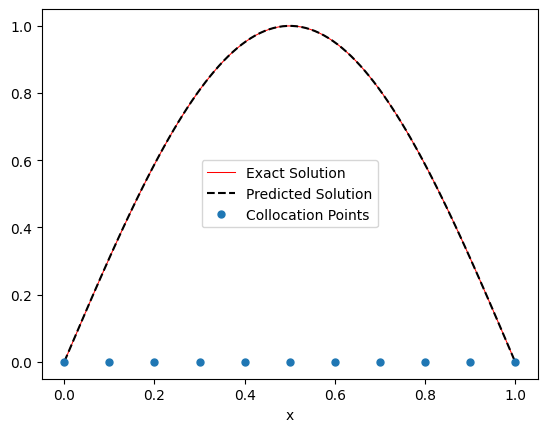

In [16]:
plt.plot(x_test,y_test,label = "Exact Solution",linestyle="-",color = "red",linewidth = 0.75)
plt.plot(x_test,y_pred,label = "Predicted Solution",linestyle="--",linewidth = 1.5,color = "black")
plt.plot(x_train,np.zeros_like(x_train),label="Collocation Points",linestyle = "None", marker = "o",markersize  =5)
plt.xlabel("x")
plt.legend()
plt.show()

### Convergence Study

In [17]:
epochs = [1000,2000,4000,8000]
L2_err = []

# generate the training set
n_train = 11
x_train = torch.linspace(0,1,n_train).reshape(-1,1)

# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1)
y_test = u_exact(x_test)

for epoch in epochs:
    u = train_PINN(x_train,epoch,verbose=False)
    y_pred = u(x_test)

    L2_err.append(L2_error(y_pred,y_test).detach().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

,Epochs,L2 error
0,1000.0,0.000007
1,2000.0,0.001671
2,4000.0,0.000966
3,8000.0,0.001155


In [18]:
train_size = [10,20,40,80,160]
L2_err = []
num_epochs = 5000

# generate the test set
n_test = 1000
x_test = torch.linspace(0,1,n_test).reshape(-1,1)
y_test = u_exact(x_test)

for n_train in train_size:
    # generate the training set
    x_train = torch.linspace(0,1,n_train).reshape(-1,1)

    u = train_PINN(x_train,num_epochs,verbose=False)
    y_pred = u(x_test)

    L2_err.append(L2_error(y_pred,y_test).detach().numpy())
    
table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,10.0,0.000023
1,20.0,0.987259
2,40.0,1.266077
3,80.0,0.000022
4,160.0,0.003238


### Convergence Study for $m=2$

In [19]:
epochs = [1000,2000,4000,8000]
L2_err = []
m=2
# generate the training set
n_train = 20
x_train = torch.linspace(0,1,n_train).reshape(-1,1)

# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1)
y_test = u_exact(x_test,m)

for epoch in epochs:
    u = train_PINN(x_train=x_train,num_epochs=epoch,m=m,verbose=False)
    y_pred = u(x_test)

    L2_err.append(L2_error(y_pred,y_test).detach().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

,Epochs,L2 error
0,1000.0,0.009231
1,2000.0,0.067875
2,4000.0,0.001738
3,8000.0,0.000566


In [20]:
train_size = [10,20,40,80,160]
L2_err = []
num_epochs = 5000
m=2

# generate the test set
n_test = 1000
x_test = torch.linspace(0,1,n_test).reshape(-1,1)
y_test = u_exact(x_test,m)

for n_train in train_size:
    # generate the training set
    x_train = torch.linspace(0,1,n_train).reshape(-1,1)

    u = train_PINN(x_train=x_train,num_epochs=num_epochs,m=m,verbose=False)
    y_pred = u(x_test)

    L2_err.append(L2_error(y_pred,y_test).detach().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,10.0,0.074487
1,20.0,0.021619
2,40.0,0.004394
3,80.0,0.241653
4,160.0,0.243441


In [21]:
y_train = u_exact(x_train,m)
x_train.requires_grad_(False)
y_train = y_train.detach().numpy()
y_pred = y_pred.detach().numpy()

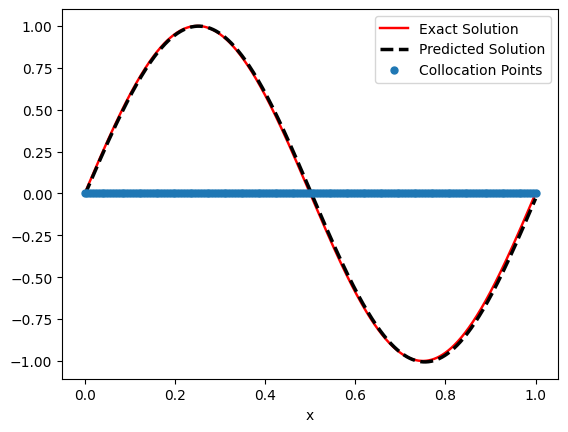

In [22]:
plt.plot(x_test,y_test,label = "Exact Solution",linestyle="-",color = "red",linewidth = 1.75)
plt.plot(x_test,y_pred,label = "Predicted Solution",linestyle="--",linewidth = 2.5,color = "black")
plt.plot(x_train,np.zeros_like(x_train),label="Collocation Points",linestyle = "None", marker = "o",markersize  =5)
plt.xlabel("x")
plt.legend()
plt.show()

### Convergence Study for $m=4$

In [23]:
epochs = [4000,8000,16000,32000]
L2_err = []
m=4
# generate the training set
n_train = 20
x_train = torch.linspace(0,1,n_train).reshape(-1,1)

# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1)
y_test = u_exact(x_test,m)

for epoch in epochs:
    u = train_PINN(x_train=x_train,num_epochs=epoch,m=m,verbose=False)
    y_pred = u(x_test)

    L2_err.append(L2_error(y_pred,y_test).detach().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

,Epochs,L2 error
0,4000.0,7.775548
1,8000.0,1.706467
2,16000.0,0.146572
3,32000.0,0.833563


In [24]:
train_size = [20,40,80,160,320]
L2_err = []
num_epochs = 10000
m=4

# generate the test set
n_test = 1000
x_test = torch.linspace(0,1,n_test).reshape(-1,1)
y_test = u_exact(x_test,m)

for n_train in train_size:
    # generate the training set
    x_train = torch.linspace(0,1,n_train).reshape(-1,1)

    u = train_PINN(x_train=x_train,num_epochs=num_epochs,m=m,verbose=False)
    y_pred = u(x_test)

    L2_err.append(L2_error(y_pred,y_test).detach().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,20.0,66.073608
1,40.0,0.378673
2,80.0,0.283537
3,160.0,1.319404
4,320.0,0.813620


In [25]:
y_train = u_exact(x_train,m)
x_train.requires_grad_(False)
y_train = y_train.detach().numpy()
y_pred = y_pred.detach().numpy()

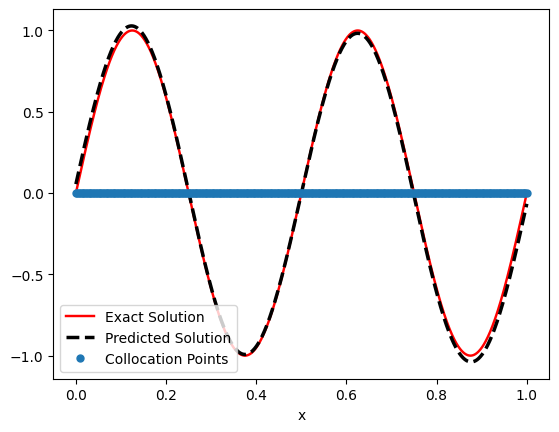

In [26]:
plt.plot(x_test,y_test,label = "Exact Solution",linestyle="-",color = "red",linewidth = 1.75)
plt.plot(x_test,y_pred,label = "Predicted Solution",linestyle="--",linewidth = 2.5,color = "black")
plt.plot(x_train,np.zeros_like(x_train),label="Collocation Points",linestyle = "None", marker = "o",markersize  =5)
plt.xlabel("x")
plt.legend()
plt.show()

Approximating highly oscillatory solutions using PINNs is challenging. As demonstrated above, an increase in the parameter $m$ correlates with an increased number of epochs required to achieve a desired accuracy. This difficulty can be mitigated by increasing either the number of collocation points or the number of hidden layers in the neural network.

## 2D Problem

Consider the following two-dimensional problem
$$
\begin{align*}
    -\Delta u +u &= (m^2\pi^2+n^2\pi^2+1)\sin(m\pi x)\sin(n\pi y),\hspace{10pt}\text{ in }(0,1)\\
    u(0)&=u(1)=0
\end{align*}
$$

The exact solution is given by $u_{mn} = \sin(m\pi x)\sin(n \pi y)$.

In [2]:
# RHS
def f(x,m=1,n=1):
    return (m**2*pi**2+n**2*pi**2+1)*sin(m*pi*x[0])*sin(n*pi*x[1])

# Exact Solution
def u_exact(x,m=1,n=1):
    return sin(m*pi*x[0])*sin(n*pi*x[1])

### Creating PINN

In [213]:
# building PINN neural network using nn.Module class
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),          # here 2 describes that we are working in 2D
            nn.ReLU(),
            nn.Linear(128, 128),           
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.net(x)
    
# incorporating automatic differentiation
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),create_graph=True)[0]

### Loss function

Here, since the boundary is 1D we sample enough points on the boundary to impose the boundary conditions into the loss function. That is, $MSE_b$ takes the form
$$
\begin{align*}
    MSE_b =\frac{1}{N_b}\sum_{k=1}^{N_b} |u(x_k)|^2
\end{align*}
$$

and $MSE_i$ has the same form except that the points are in 2D.

In [263]:
def compute_loss(model: nn.Module, x_train_i: torch.Tensor,x_train_b:torch.Tensor,m=1,n=1):
    # evaluating u(x), f(x), du/dx, d^2u/dx^2 at training data points
    x_train = torch.cat([x_train_i,x_train_b])
    x_train.requires_grad_(True)
    u = model(x_train)                      # model prediction on training data
    du = grad(u,x_train)
    # d2u = grad(du,x_train_i)

    du_dx = du[:, 0].view(-1, 1) # du/dx component
    du_dy = du[:, 1].view(-1, 1) # du/dy component

    # Calculate second derivatives: d^2u/dx^2 and d^2u/dy^2
    d2u_dx2 = grad(du_dx, x_train)[:, 0].view(-1, 1) # Take x component again
    d2u_dy2 = grad(du_dy, x_train)[:, 1].view(-1, 1) # Take y component again

    # Calculate the 2D Laplacian: Delta u = d^2u/dx^2 + d^2u/dy^2
    # For the problem: -Delta u + u - f = 0, so residual is - (d2u_dx2 + d2u_dy2) + u - f
    d2u = d2u_dx2 + d2u_dy2

    residual_i = -d2u[:len(x_train_i)] + u[:len(x_train_i)] - f(x_train_i,m,n)     # ODE-based interior residual
    interior_loss = torch.mean(residual_i**2)   # mean-squared interior loss

    #calculating boundary loss for problem
    residual_b = u[len(x_train_i):]
    boundary_loss = torch.mean(residual_b**2)    # mean-squared boundary loss
    
    return interior_loss + boundary_loss

### Generating Training and test dataset

In [264]:
def generate_collocation_points(N_i):
    xx = torch.linspace(0,1,N_i+2)[1:-1]
    yy = torch.linspace(0,1,N_i+2)[1:-1]
    x = []
    for i in range(len(xx)):
        for j in range(len(yy)):
            x.append([xx[i],yy[j]])
    return torch.tensor(x, dtype=torch.float32)

def generate_boundary_points(N_b):
    ref = torch.linspace(0,1,N_b+2)[1:-1]
    x = []
    for i in range(len(ref)):
        x.append([ref[i],0])
        x.append([ref[i],1])
        x.append([0,ref[i]])
        x.append([1,ref[i]])
    x.append([0,0])
    x.append([1,0])
    x.append([0,1])
    x.append([1,1])
    return torch.tensor(x, dtype=torch.float32)

The number of collocation points in the interior of square is $N_i^2$ and the number of boundary points are $4(N_b+1)$, where $N_i$ and $N_b$ are the inputs of `generate_collocation_points` and `generate_boundary_points` respectively. 

In [265]:
# interior points
N_i = 30
x_train_i = generate_collocation_points(N_i)
x_train_i

tensor([[0.0323, 0.0323],
        [0.0323, 0.0645],
        [0.0323, 0.0968],
        ...,
        [0.9677, 0.9032],
        [0.9677, 0.9355],
        [0.9677, 0.9677]])

In [266]:
# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b)
x_train_b

tensor([[0.0667, 0.0000],
        [0.0667, 1.0000],
        [0.0000, 0.0667],
        [1.0000, 0.0667],
        [0.1333, 0.0000],
        [0.1333, 1.0000],
        [0.0000, 0.1333],
        [1.0000, 0.1333],
        [0.2000, 0.0000],
        [0.2000, 1.0000],
        [0.0000, 0.2000],
        [1.0000, 0.2000],
        [0.2667, 0.0000],
        [0.2667, 1.0000],
        [0.0000, 0.2667],
        [1.0000, 0.2667],
        [0.3333, 0.0000],
        [0.3333, 1.0000],
        [0.0000, 0.3333],
        [1.0000, 0.3333],
        [0.4000, 0.0000],
        [0.4000, 1.0000],
        [0.0000, 0.4000],
        [1.0000, 0.4000],
        [0.4667, 0.0000],
        [0.4667, 1.0000],
        [0.0000, 0.4667],
        [1.0000, 0.4667],
        [0.5333, 0.0000],
        [0.5333, 1.0000],
        [0.0000, 0.5333],
        [1.0000, 0.5333],
        [0.6000, 0.0000],
        [0.6000, 1.0000],
        [0.0000, 0.6000],
        [1.0000, 0.6000],
        [0.6667, 0.0000],
        [0.6667, 1.0000],
        [0.0

In [267]:
def generate_test(N):
    xx = torch.linspace(0,1,N)
    yy = torch.linspace(0,1,N)
    x = []
    for i in range(len(xx)):
        for j in range(len(yy)):
            x.append([xx[i],yy[j]])
    return torch.tensor(x, dtype=torch.float32)

The test set consists of uniformly spaced points in $[0,1]$. 

In [268]:
N = 35
x_test = generate_test(N)
x_test

tensor([[0.0000, 0.0000],
        [0.0000, 0.0294],
        [0.0000, 0.0588],
        ...,
        [1.0000, 0.9412],
        [1.0000, 0.9706],
        [1.0000, 1.0000]])

In [269]:
y_test = u_exact(x_test.T)
y_test

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.6064e-08,
        -8.0664e-09,  7.6427e-15])

### Training and predicting using PINN

Here, Adam optimizer with learning rate 0.001 is used to minimize the loss function described above. 

In [273]:
# defining a function to train PINN
def train_PINN(x_train_i,x_train_b,num_epochs,m=1,n=1,verbose = True, create_graph = True):
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    N_i_val = int(0.05*len(x_train_i))
    N_b_val = int(0.05*len(x_train_b))

    N_i_train = len(x_train_i) - N_i_val
    N_b_train = len(x_train_b) - N_b_val

    x_training_i , x_validation_i = random_split(TensorDataset(x_train_i) , [N_i_train,N_i_val])
    x_training_b , x_validation_b = random_split(TensorDataset(x_train_b) , [N_b_train,N_b_val])
    

    x_training_i = x_training_i.dataset.tensors[0][x_training_i.indices]
    x_validation_i = x_validation_i.dataset.tensors[0][x_validation_i.indices]

    x_training_b = x_training_b.dataset.tensors[0][x_training_b.indices]
    x_validation_b = x_validation_b.dataset.tensors[0][x_validation_b.indices]
    print(x_training_i)

    # Iterate training over epochs
    for epoch in range(num_epochs):

        model.train()
        train_loss = compute_loss(model, x_training_i,x_training_b,m,n)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        model.eval()  # Set model to evaluation mode
        val_loss = compute_loss(model, x_validation_i, x_validation_b, m, n)

        if epoch % 10 == 0:
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())

        if epoch % 500 == 0 and verbose ==True:
            print(f"Full Training Epoch {epoch}, Training Loss: {train_loss.item():.6f}, Validation Loss: {val_loss.item():.6f}")

    if create_graph == True:
        
        plt.plot(train_losses, label = "Training Loss")
        plt.plot(val_losses, label = "Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Curves")
        plt.legend()
        plt.grid(True)
        plt.show()
    return model

In [274]:
len(x_train_b)

60

In [275]:
num_epochs = 10000
u = train_PINN(x_train_i,x_train_b,num_epochs)

tensor([[0.6129, 0.7419],
        [0.5806, 0.6452],
        [0.8387, 0.8710],
        ...,
        [0.8387, 0.7419],
        [0.8387, 0.0968],
        [0.0968, 0.1935]])
Full Training Epoch 0, Training Loss: 266.619720, Validation Loss: 21.138685
Full Training Epoch 500, Training Loss: 8.894961, Validation Loss: 139.385742
Full Training Epoch 1000, Training Loss: 8.317059, Validation Loss: 141.482681
Full Training Epoch 1500, Training Loss: 8.217102, Validation Loss: 140.871429
Full Training Epoch 2000, Training Loss: 7.900363, Validation Loss: 141.571991
Full Training Epoch 2500, Training Loss: 7.185483, Validation Loss: 141.923828
Full Training Epoch 3000, Training Loss: 7.113175, Validation Loss: 141.631989
Full Training Epoch 3500, Training Loss: 7.111110, Validation Loss: 141.720993
Full Training Epoch 4000, Training Loss: 7.110329, Validation Loss: 141.675507
Full Training Epoch 4500, Training Loss: 7.109832, Validation Loss: 141.789932
Full Training Epoch 5000, Training Loss: 7.

KeyboardInterrupt: 

In [125]:
# Predicting using obtained u
y_pred = u(x_test)[:,0]
y_pred

tensor([-1.3396e-02, -8.2148e-03, -5.2781e-03, -3.8081e-03, -3.2345e-03,
        -3.1678e-03, -3.3548e-03, -3.6440e-03, -3.9570e-03, -4.2601e-03,
        -4.5404e-03, -4.7909e-03, -5.0055e-03, -5.1783e-03, -5.3086e-03,
        -5.4003e-03, -5.4600e-03, -5.4881e-03, -5.4674e-03, -5.3565e-03,
        -5.0945e-03, -4.6263e-03, -3.9421e-03, -3.1242e-03, -2.3856e-03,
        -2.0917e-03, -2.7587e-03, -5.0292e-03, -9.6285e-03, -1.7307e-02,
        -8.3714e-03,  4.6385e-03,  1.4759e-02,  2.2633e-02,  2.8794e-02,
         3.3656e-02,  3.7532e-02,  4.0641e-02,  4.3136e-02,  4.5122e-02,
         4.6671e-02,  4.7838e-02,  4.8658e-02,  4.9155e-02,  4.9347e-02,
         4.9241e-02,  4.8841e-02,  4.8146e-02,  4.7153e-02,  4.5864e-02,
         4.4279e-02,  4.2383e-02,  4.0111e-02,  3.7323e-02,  3.3776e-02,
         2.9119e-02,  2.2905e-02,  1.4609e-02,  3.6515e-03, -1.0576e-02,
        -6.2177e-03,  1.4166e-02,  3.0956e-02,  4.4735e-02,  5.6060e-02,
         6.5400e-02,  7.3113e-02,  7.9469e-02,  8.4

In [126]:
y_pred.shape == y_test.shape

True

### Calculating $L^2$ error of the solution

In [127]:
def L2_error(y_pred,y_test):
    return torch.sum((y_test - y_pred)**2)

In [128]:
error = L2_error(y_pred,y_test)
print(f"L2_error of approximation: {error}")

L2_error of approximation: 78.33918762207031


### Plotting the solution

In [116]:
y_train_i = u_exact(x_train_i)
y_train_b = u_exact(x_train_b)
x_train_i.requires_grad_(False)
y_train_i = y_train_i.detach().numpy()
y_train_b = y_train_b.detach().numpy()
y_pred = y_pred.detach().numpy()

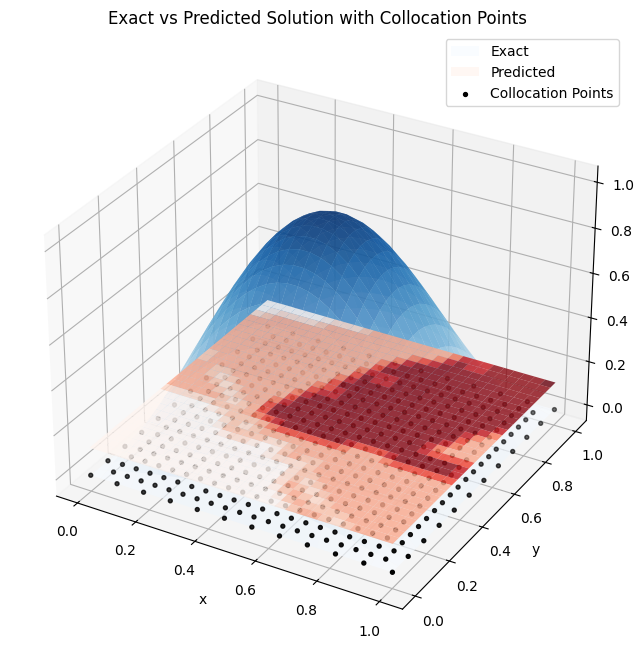

In [117]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# %matplotlib widget

# Reshape test data for surface plots
N = int(np.sqrt(x_test.shape[0]))
X = x_test[:, 0].reshape(N, N)
Y = x_test[:, 1].reshape(N, N)
y_pred = y_pred.reshape(N, N)
y_test = y_test.reshape(N, N)
x_train = np.vstack([x_train_i,x_train_b])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Surface: Exact solution
ax.plot_surface(X, Y, y_test, alpha = 0.7, cmap=cm.Blues, label='Exact')

# Surface: Predicted solution (wireframe or different alpha)
ax.plot_surface(X, Y, y_pred, alpha = 0.8, cmap=cm.Reds, label="Predicted")

# Scatter: Collocation points at z=0
ax.scatter(x_train[:, 0], x_train[:, 1], np.zeros_like(x_train[:, 0]),
           color='black', s=8, marker='o', label='Collocation Points')

# Labels and legend
ax.set_title("Exact vs Predicted Solution with Collocation Points")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.legend()
plt.show()

In [118]:
import plotly.graph_objects as go
import numpy as np

# Reshape data (assuming square grid)
N = int(np.sqrt(x_test.shape[0]))
X = x_test[:, 0].reshape(N, N)
Y = x_test[:, 1].reshape(N, N)
y_pred = y_pred.reshape(N, N)
y_test = y_test.reshape(N, N)
x_train = np.vstack([x_train_i,x_train_b])

fig = go.Figure()

# Predicted surface
fig.add_trace(go.Surface(z=y_pred, x=X, y=Y, colorscale='Blues', name='Predicted',showlegend=True,showscale=False))

# Exact surface overlay
fig.add_trace(go.Surface(z=y_test, x=X, y=Y, colorscale='Reds', opacity=0.5, name='Exact',showlegend=True,showscale=False))

# Collocation points
# x_col = x_train.detach().cpu().numpy()
fig.add_trace(go.Scatter3d(
    x=x_train[:, 0], y=x_train[:, 1], z=np.zeros_like(x_train[:, 0]),
    mode='markers', marker=dict(size=3, color='black'),
    name='Collocation Points',
    showlegend=True
))

fig.update_layout(
    title="PINN: Predicted vs Exact Solution",
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='u(x,y)'),
    width=900, height=700
)
fig.show()
